In [ ]:
https://github.com/QuantCS109/TrumpTweets/blob/master/notebooks_features/Trump_Word2Vec.ipynb

# Word2Vec Algorithm

This is an implementation of the [Word2Vec algorithm](https://en.wikipedia.org/wiki/Word2vec) using the skip-gram architecture. 
I'm adapting code from a course in Udacity to our problem. The original code is here: https://github.com/udacity/deep-learning-v2-pytorch/tree/master/word2vec-embeddings 

In [1]:
import sys
sys.path.append('..') #to add top-level to path
sys.path.append('../modules') #to add top-level to path

from modules.project_helper import TweetData
from modules.skipgram import get_batches, SkipGramNeg, NegativeSamplingLoss, subsampling
from modules.skipgram import cosine_similarity, plot_similar_words
import numpy as np

import torch
import torch.optim as optim

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

import warnings
warnings.filterwarnings("ignore")

## Loading data

In [2]:
# time series of trump archives to be able to train the model sequentially
data = TweetData('../data/intermediate_data/trump_archive_ts/trump_archive_db_1910.csv')
# full data set
# data = TweetData('data/trump_archive_db.csv')

In [3]:
# get list of words
words = data.words
print(words[:30])

['while', 'the', 'do', 'nothing', 'democrats', 'fail', 'the', 'american', 'people', 'and', 'continue', 'the', 'impeachment', 'scam', 'my', 'administration', 'will', 'continue', 'to', 'deliver', 'real', 'results', 'as', 'seen', 'over', 'the', 'past', 'month', 'below', 'the']


In [4]:
print("Total words in Trump's tweets: {}".format(len(words)))
print("Unique words: {}".format(len(set(words))))

Total words in Trump's tweets: 395944
Unique words: 4583


In [5]:
# These are two dictionaries to convert words to integers and back again (integers to words). 
# The integers are assigned in descending frequency order, so the most frequent word ("the") 
# is given the integer 0 and the next most frequent is 1, etc. 

vocab_to_int, int_to_vocab = data.vocab_to_int, data.int_to_vocab
int_words = data.int_words

print(int_words[:30])

[253, 0, 47, 140, 75, 1451, 0, 104, 33, 2, 402, 0, 686, 713, 32, 279, 10, 402, 1, 1381, 306, 559, 39, 505, 107, 0, 698, 1061, 3512, 0]


## Training


In [6]:
#device = 'cuda' if torch.cuda.is_available() else 'cpu'
device = 'cpu'

# Get our noise distribution
threshold = 1e-4 #lowered threshold as used in Word2Vec algorithm since we have smaller sample
freqs, train_words = subsampling(threshold, int_words)
word_freqs = np.array(sorted(freqs.values(), reverse=True))
unigram_dist = word_freqs/word_freqs.sum()
noise_dist = torch.from_numpy(unigram_dist**(0.75)/np.sum(unigram_dist**(0.75)))

#original is 5, skipgram paper suggests up to 20 for small data sets
N_negative_sampling = 7

# instantiating the model
embedding_dim = 100
model = SkipGramNeg(len(vocab_to_int), embedding_dim, noise_dist=noise_dist).to(device)

# using Negative Sampling Loss as our loss function
criterion = NegativeSamplingLoss() 

# Choosing optimzier
optimizer = optim.Adam(model.parameters(), lr=0.003)

# train for some number of epochs
print_every = 200
steps = 0
epochs = 20


for e in range(epochs):
    
    # get our input, target batches
    for input_words, target_words in get_batches(train_words, 512):
        steps += 1
        inputs, targets = torch.LongTensor(input_words), torch.LongTensor(target_words)
        inputs, targets = inputs.to(device), targets.to(device)
        
        # input, output, and noise vectors
        input_vectors = model.forward_input(inputs)
        output_vectors = model.forward_output(targets)
        noise_vectors = model.forward_noise(inputs.shape[0], N_negative_sampling)

        # negative sampling loss
        loss = criterion(input_vectors, output_vectors, noise_vectors)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # loss stats
        if steps % print_every == 0:
            print("Epoch: {}/{}".format(e+1, epochs))
            print("Loss: ", loss.item()) # avg batch loss at this point in training
            valid_examples, valid_similarities = cosine_similarity(model.in_embed, device=device)
            _, closest_idxs = valid_similarities.topk(6)

            valid_examples, closest_idxs = valid_examples.to('cpu'), closest_idxs.to('cpu')
            for ii, valid_idx in enumerate(valid_examples):
                closest_words = [int_to_vocab[idx.item()] for idx in closest_idxs[ii]][1:]
                print(int_to_vocab[valid_idx.item()] + " | " + ', '.join(closest_words))
            print("...\n")

Epoch: 1/20
Loss:  8.298316955566406
much | swing, sarah, the, length, motto
s | chance, yesterday, session, sell, express
their | poll, prayer, recover, version, forum
what | march, going, pages, ultimately, instead
big | anniversary, terrorists, play, comments, taken
will | together, letting, should, corrupt, days
our | billions, products, met, point, ask
new | ever, prayers, heather, abe, kemp
award | true, regardless, referred, schiff, however
outside | barely, spirit, nick, comcast, cup
king | security, minneapolis, opinions, setbacks, south
colorado | cable, baseball, technology, fortune, mails
standing | across, israeli, n, responsibility, dropping
rating | returned, near, study, thrown, camp
follow | farmers, un, greatly, birth, blood
lied | officially, donation, build, someday, deadline
...

Epoch: 2/20
Loss:  4.9751057624816895
all | seek, voters, pressure, properly, general
has | interesting, rick, departing, killing, court
for | ryan, soon, putting, brett, syria
be | encour

Epoch: 9/20
Loss:  2.730422258377075
is | like, just, know, about, the
when | didnt, by, is, mess, about
fake | report, incorrect, presidency, when, long
get | disgusting, people, getting, a, really
been | for, and, else, the, one
for | the, in, and, will, c
country | trade, much, wall, our, open
very | a, well, good, and, energy
sanctuary | strong, guilty, law, borders, position
head | something, pageant, idea, see, however
gang | asked, gangs, ms, limbaugh, subsidize
changed | o, a, lawyers, know, rebuilt
coverage | pollster, concentration, agent, fast, granted
fire | modern, protecting, not, saved, completely
signing | demand, order, will, rule, very
lied | picks, unrelated, asked, failing, even
...

Epoch: 10/20
Loss:  2.8310461044311523
when | didnt, by, about, dumb, is
today | honor, tomorrow, great, bless, thank
country | trade, much, our, wall, open
been | for, and, the, else, hunt
make | beat, on, thank, also, all
to | in, the, americans, we, people
should | president, or, bro

Epoch: 18/20
Loss:  2.655994415283203
to | the, will, tomorrow, i, start
about | questions, lied, sources, when, exist
now | lottery, so, southern, luther, they
and | their, as, only, do, the
only | they, and, their, cost, self
as | and, j, for, yourself, demands
u | s, tariffs, countries, trade, pay
but | does, dont, hope, always, longer
received | cpac, pm, philippines, honored, agent
soldiers | syria, troops, broken, home, isis
terrorism | islamic, individuals, khan, thinking, solidarity
create | midas, heard, features, somebody, building
necessary | border, creative, strong, whats, democrats
lyin | ted, cruz, investigating, oath, leaking
senators | replace, leadership, working, repeal, raise
tom | brady, pa, hes, salt, holes
...

Epoch: 18/20
Loss:  2.4753682613372803
media | news, fake, corrupt, lamestream, cnn
many | so, jinping, eu, comparison, being
up | had, they, shifty, elections, results
not | that, of, does, the, highly
do | they, or, perhaps, and, improve
never | why, inq

In [7]:
#If you wanna save the model
#torch.save(model,'../models/tweet_embeddings/trump_rnn_1910.net')

## Visualizing the word vectors

Below we'll use T-SNE to visualize how our high-dimensional word vectors cluster together. T-SNE is used to project these vectors into two dimensions while preserving local stucture. Check out [this post from Christopher Olah](http://colah.github.io/posts/2014-10-Visualizing-MNIST/) to learn more about T-SNE and other ways to visualize high-dimensional data.
Wiki on T-SNE, a bit complicated! https://en.wikipedia.org/wiki/T-distributed_stochastic_neighbor_embedding

In [8]:
# getting embeddings from the embedding layer of our model, by name
embeddings = model.in_embed.weight.to('cpu').data.numpy()

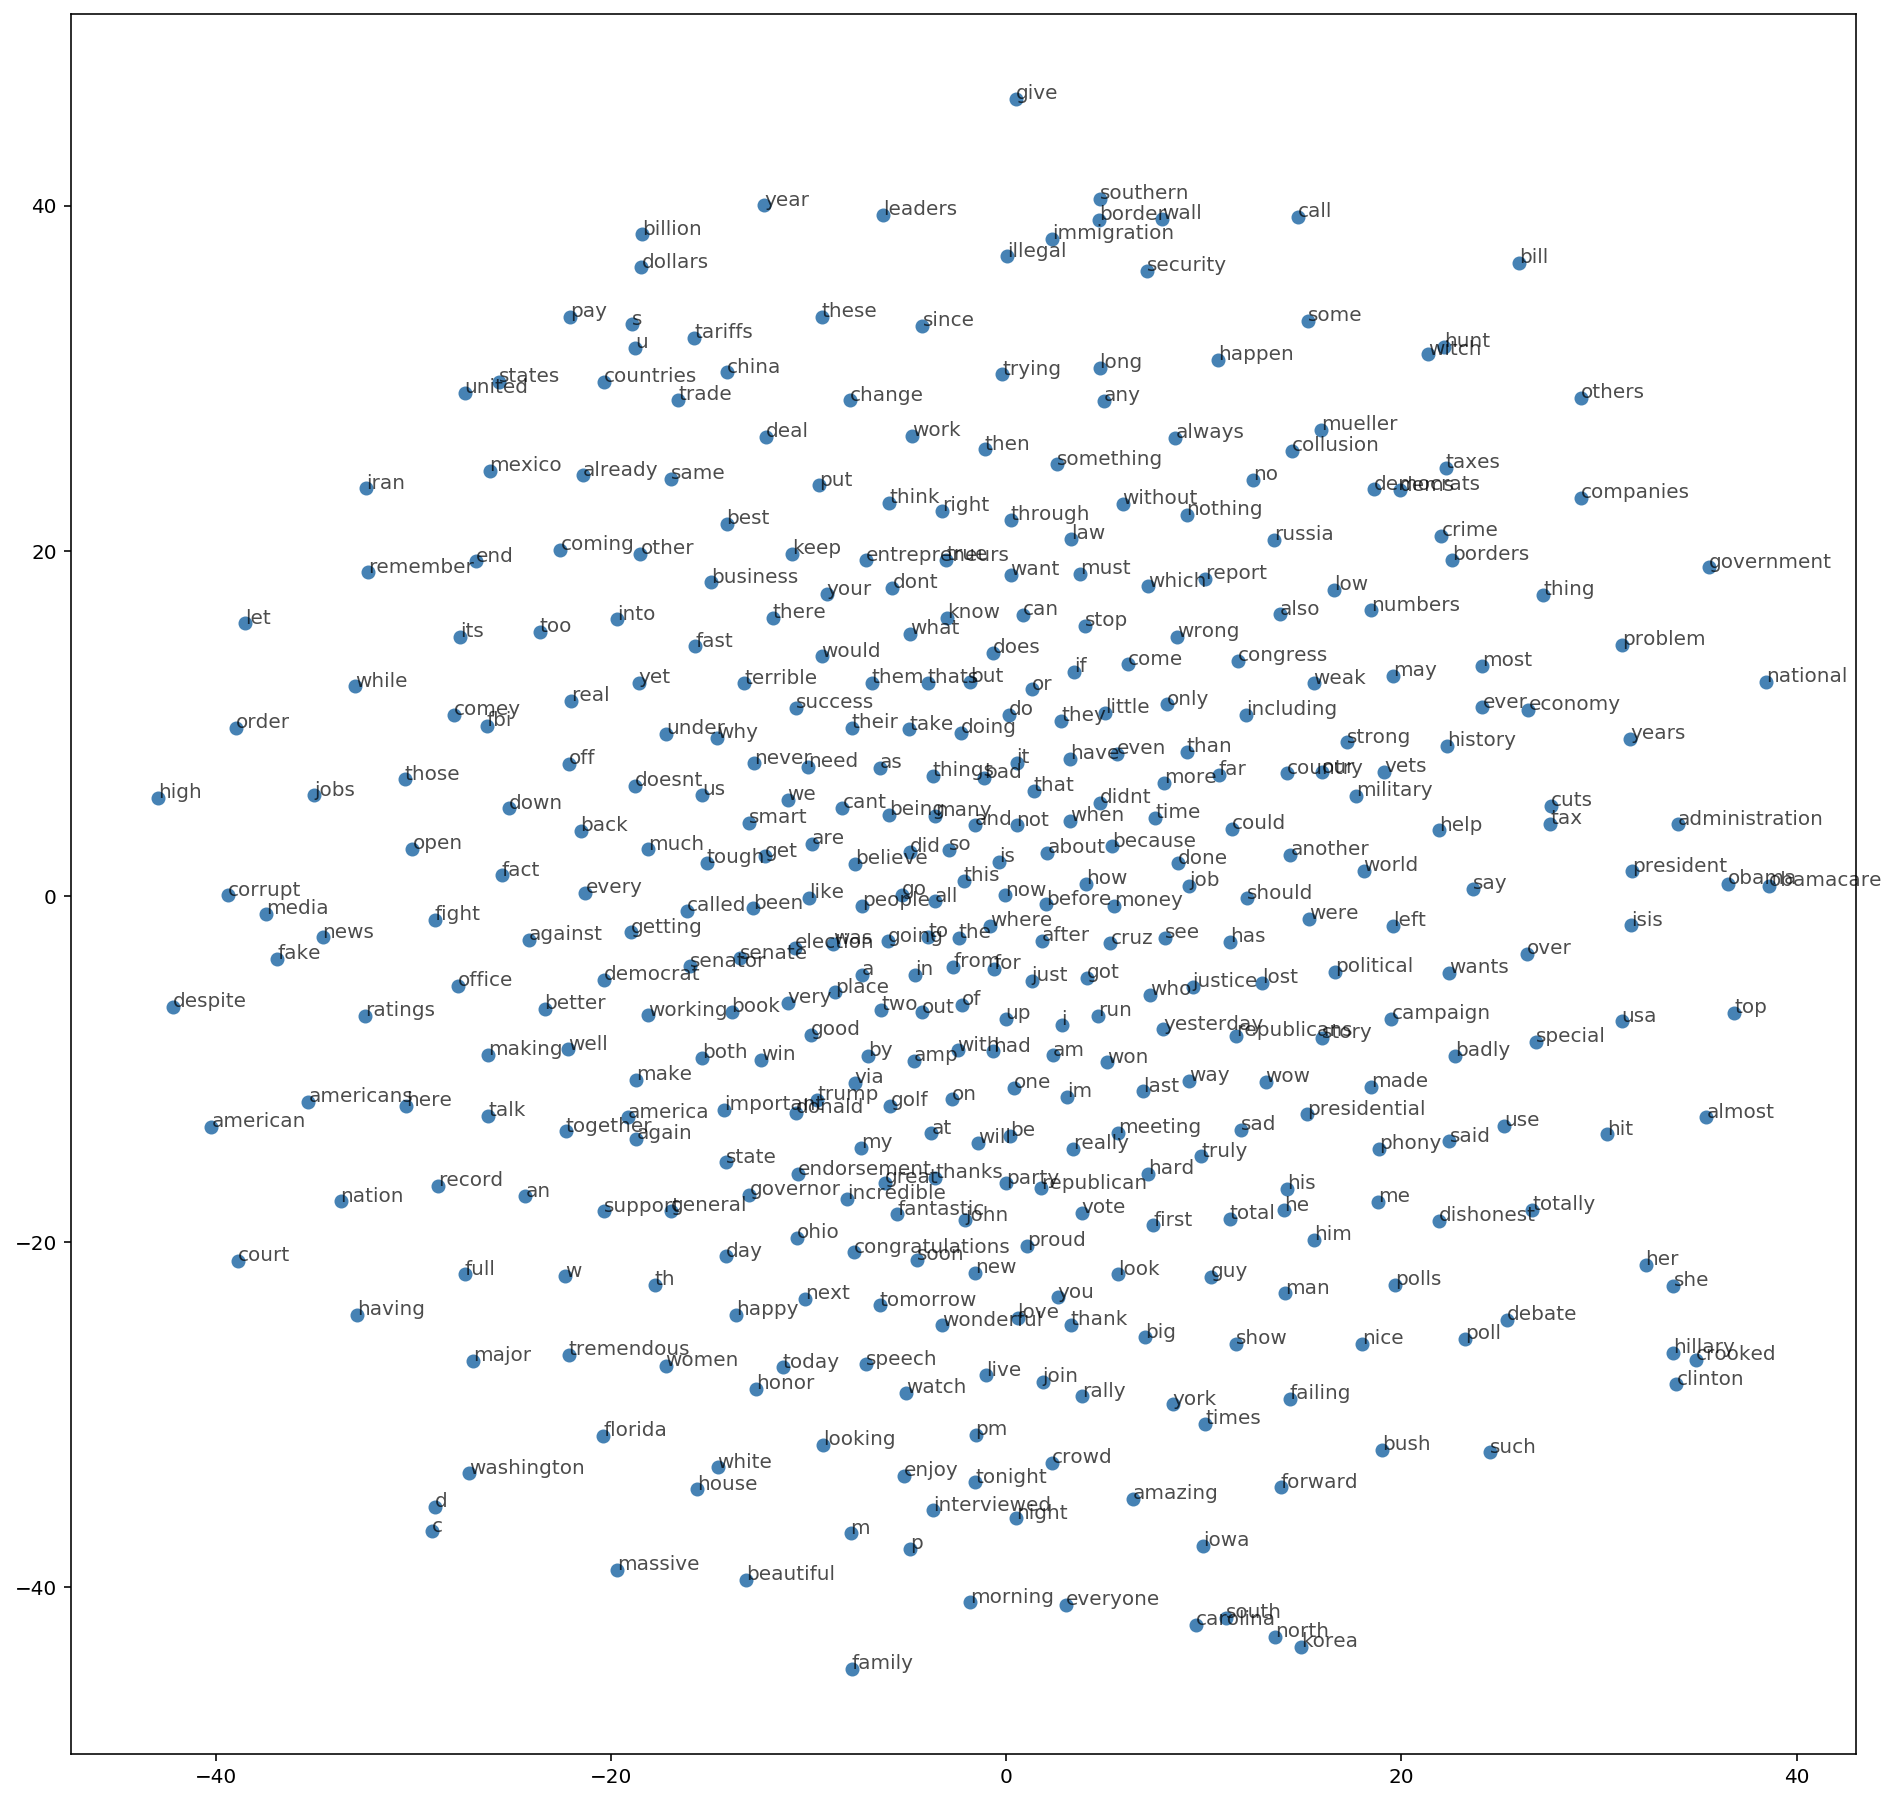

In [9]:
viz_words = 400
tsne = TSNE()
embed_tsne = tsne.fit_transform(embeddings[:viz_words, :])

fig, ax = plt.subplots(figsize=(16, 16))
for idx in range(viz_words):
    plt.scatter(*embed_tsne[idx, :], color='steelblue')
    plt.annotate(int_to_vocab[idx], (embed_tsne[idx, 0], embed_tsne[idx, 1]), alpha=0.7)

In [10]:
# If you wanna load a pre-trained model
model = torch.load('../models/tweet_embeddings/trump_rnn_1911.net')
keys = ['collusion', 'hillary', 'hotel', 'democrats', 'campaign', 'fed', 'china', 'mexico', 'tariffs','tax']
embeddings = model.in_embed.weight.to('cpu').data.numpy()

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

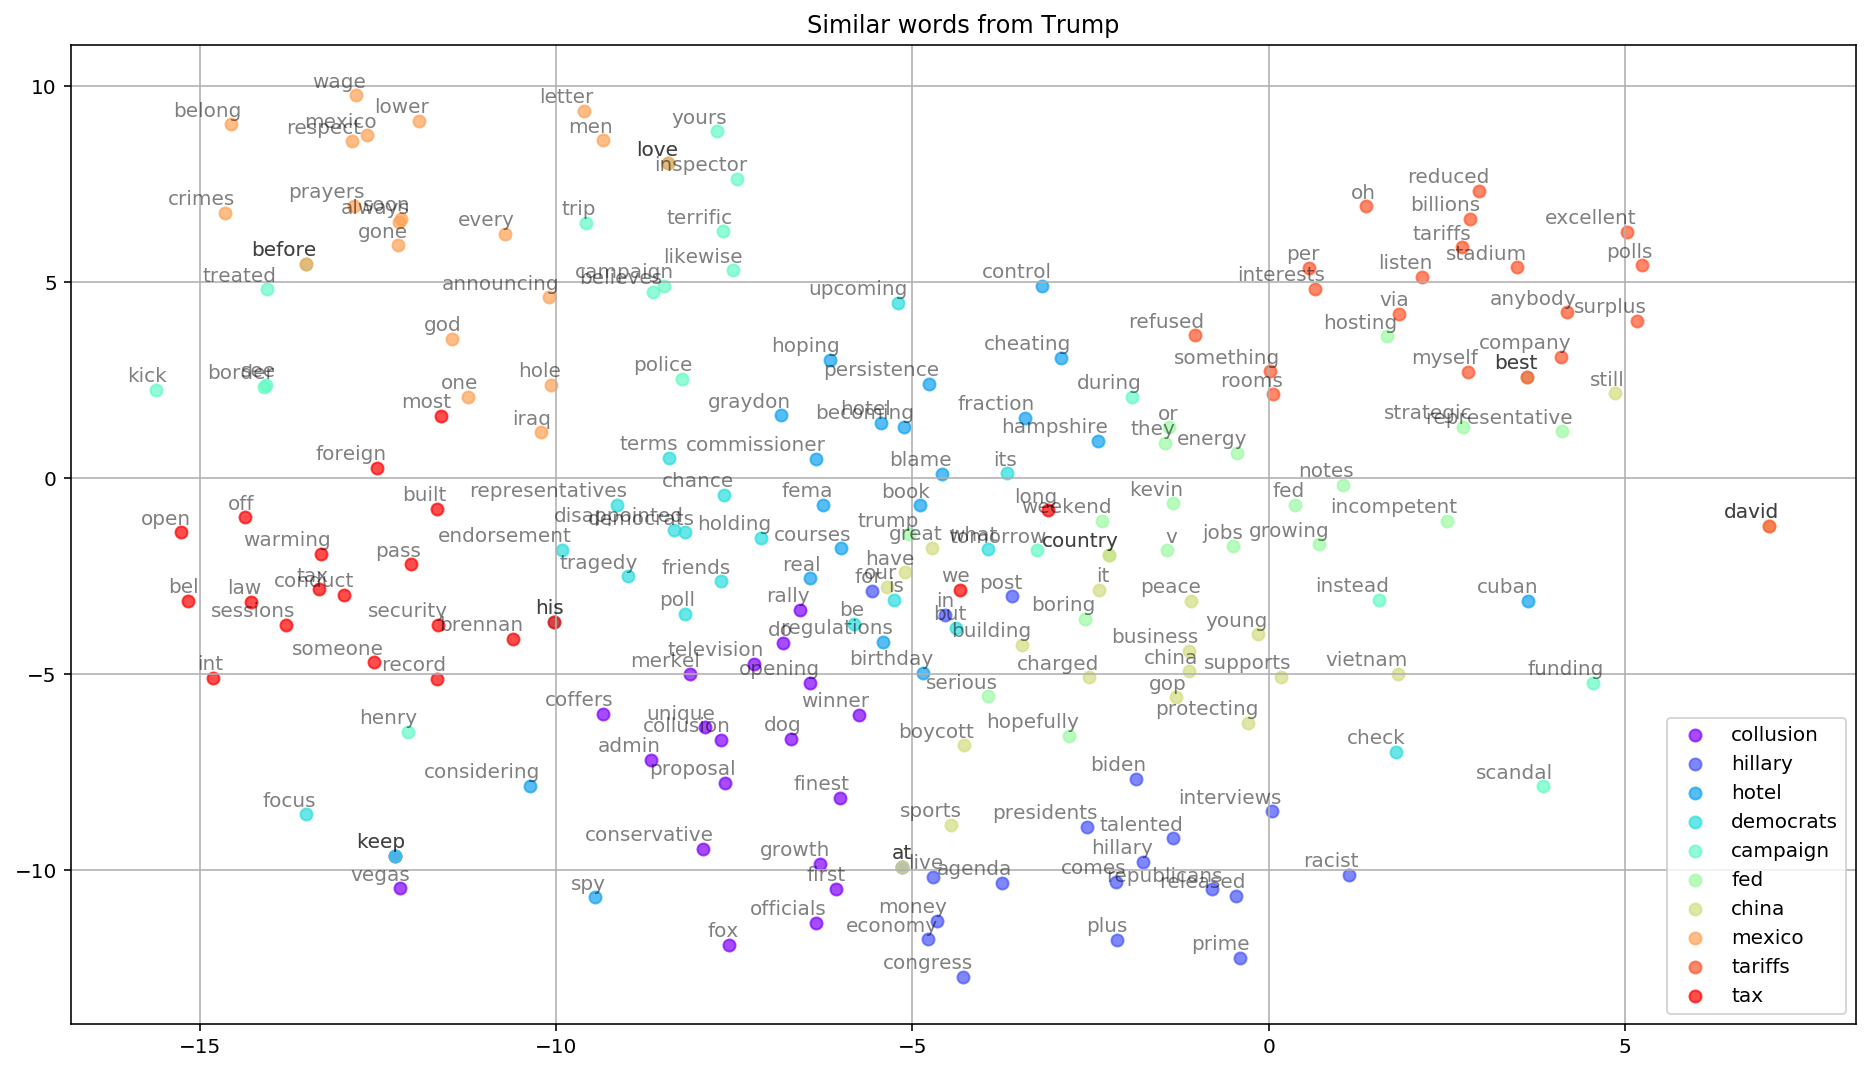

In [11]:
plot_similar_words(keys, model, vocab_to_int, int_to_vocab, num=20, file=None)

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

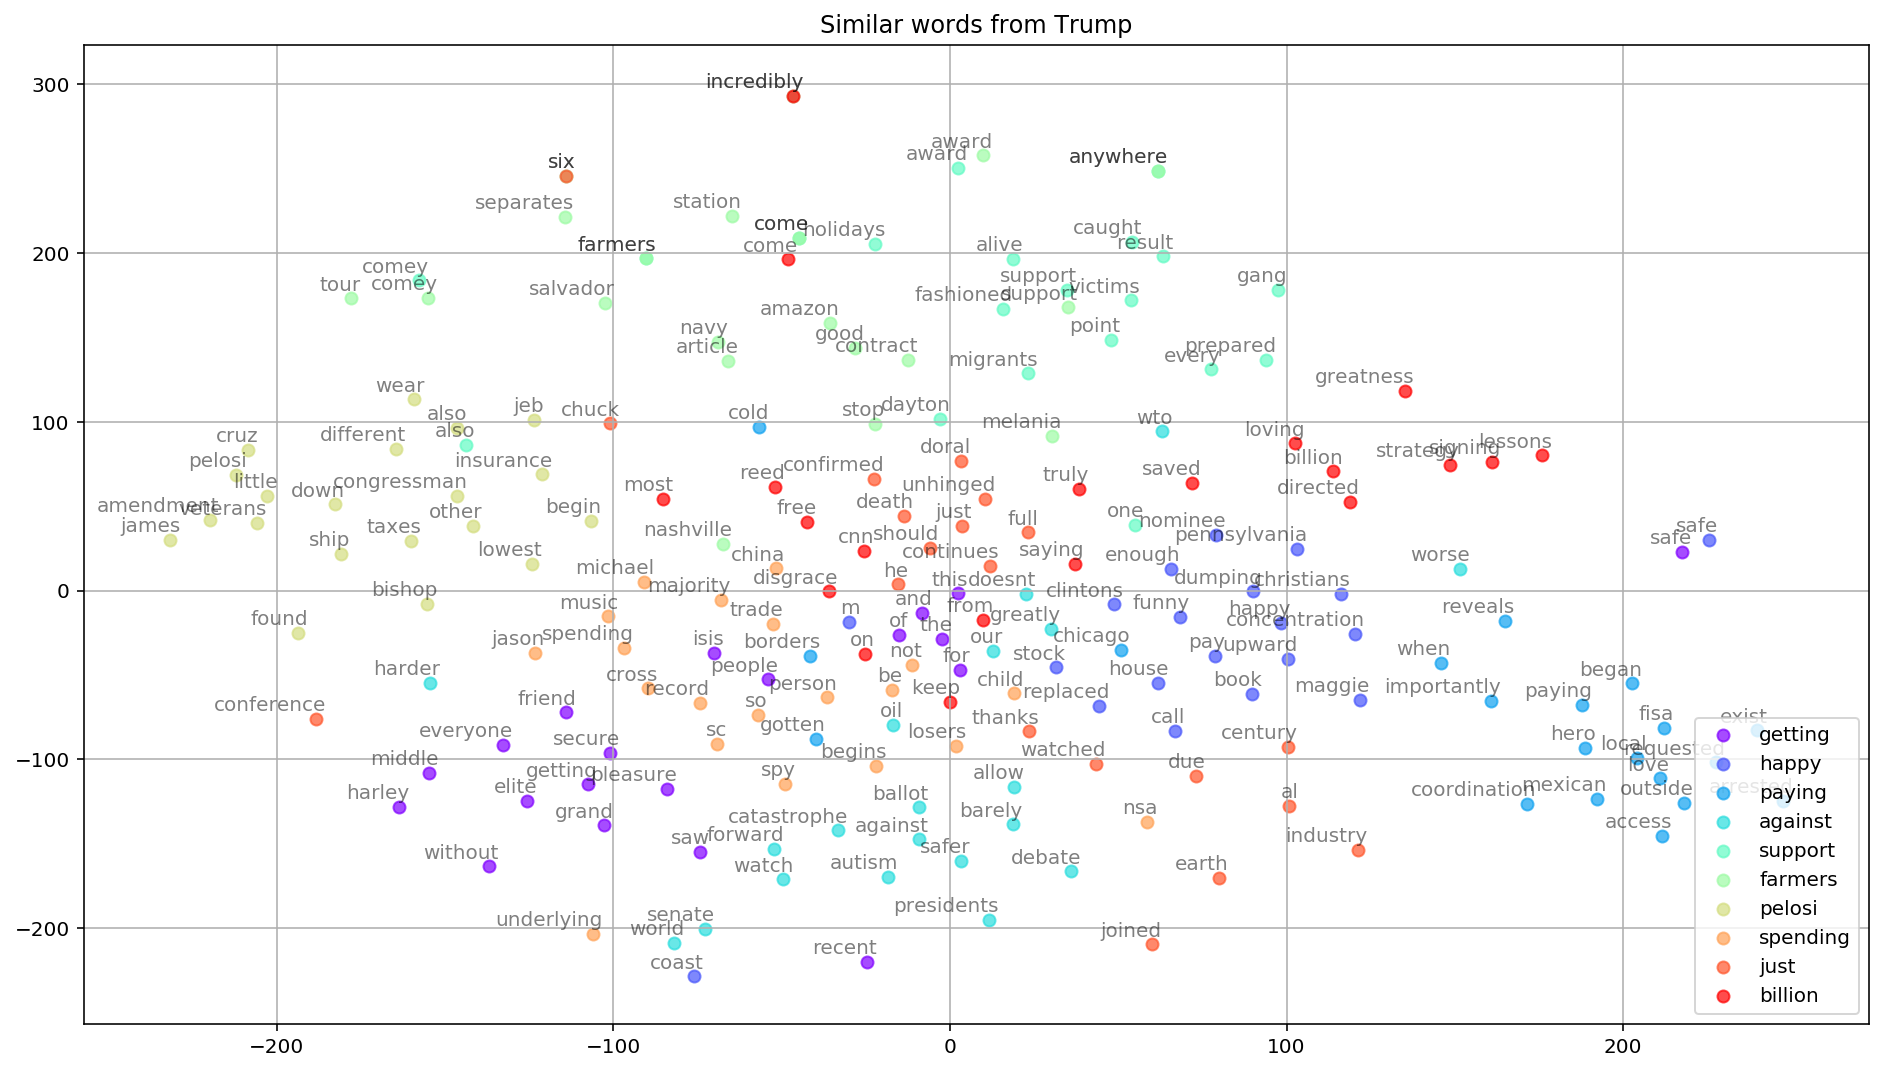

In [12]:
trump_returns_words = ['getting', 
'happy',       
'paying',      
'against',     
'support',     
'farmers',      
'pelosi',       
'spending',    
'just',         
'billion']  
plot_similar_words(trump_returns_words, model, vocab_to_int, int_to_vocab, num=20, file=None)